In [25]:
import Bmtcnn

import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import numpy as np

import os 
import random

import csv

import datetime
import cv2
import timeit

import pandas as pd

import pickle as pkl

import mtcnn

import cvlib

import glob

from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Dense,GlobalAveragePooling2D
import pkg_resources
from mtcnn.network.factory import NetworkFactory

from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Activation,Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K


from enum import Enum

from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from termcolor import colored

from shutil import copyfile
from pathlib import Path

In [26]:
# globals..
#for initial experiments and manipulations
pos_path='as_received_data\\aligned'
neg_path='as_received_data\\negative'

# for model cells and onwards
Neg_Dir= 'data\\negative'
Pos_Dir= 'data\\aligned'  
Models_Dir= 'preTrainedModels'

Wrong_Dir='wrongPrediction'

Results_Dir= 'results'
Results_File_Path= Results_Dir+'\\'+'results.csv'

Results_head=["comment","model_comment","date_time","batch",
             "learning_rate","epochs","time_ms","accuracy","recall","precision"]



In [27]:
# candidate models
class Model_cv2_haarcascade():
    def __init__(self,in_scale= 1.02, in_minNeighbors= 4):
        """
        assuming you have the same folder and file I had. you can modify it if not.
        
        you can download the used model from:
        https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
        """
        self.Models_Dir= 'preTrainedModels'
        self.model_path= Models_Dir + '//' + 'haarcascade_frontalface_default.xml'
        self.classifier = cv2.CascadeClassifier(self.model_path)
        
        self.dest_size= 50
        self.scale= in_scale
        self.minNeighbors= in_minNeighbors
        
    def transform_predict(self, image):
        """
        @param: image    an already "imread" image
        
        Result:  True if faces are found, False otherwise. (about 5 millisecond run time)
        
        the function turns the image to greyscale and reshapes to a (50,50) size
        which was the size I tested the model and parameters upon.
        
        usage example: 
            model= Model_cv2_haarcascade()
            image = cv2.imread("Rudolf_Schuster_0001.jpg")
            model.transform_predict(image)
            
        
        """
        grey= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized= cv2.resize(grey,(self.dest_size,self.dest_size),interpolation =cv2.INTER_AREA)
        bboxes = self.classifier.detectMultiScale(resized,self.scale,self.minNeighbors)
        if len(bboxes)>0:
            return True
        else:
            return False
    



class DirType(Enum):
    Negative = 0
    Positive = 1
    
    
class Pmtcnn():
    """
    post processes mtcnn for aligned faces accurate detection
    
    Prequisits- make sure you installed & imported the standard mtcnn
                (pip install mtcnn, then import mtcnn)
    
    """
    def __init__(self,scale_factor=0.709):
        self.model = mtcnn.MTCNN(scale_factor=scale_factor)
        self.dest_size= 50  # the target image size

    def transform_detect_aligned(self,image):
        """
        @param: image expects an image after it was loaded
        example: 
                image = PIL.Image.open(neg_image_path)
                
        transforms image to destination size and detects aligned faces
        
        Returns:
                if 1 landmark exceeds image size- returns False
                if all landmarks within image size= return True
                
                also assumes if there is 1 non-aligned face- returns false
        """
        image= image.resize((self.dest_size, self.dest_size), resample=PIL.Image.LANCZOS)
        image = image.convert('RGB')
        pixels = np.asarray(image)
        
        results = self.model.detect_faces(pixels)
        if len(results)==0:
            return False # didn't detect
        
        # could iterate once..but fot now I'll keep safe 
        for result in results:
            for key, loc in result['keypoints'].items():
                # just to be safe, adding "below zero conditions"
                if loc[0]>image.size[0] or loc[1]>image.size[1] or loc[0]<0 or loc[1]<0:
                    return False   
        
        return True
    
    def change_scale_and_image_size(self,scale_factor=0.709,dest_size=50 ):
        self.model = mtcnn.MTCNN(scale_factor=scale_factor)
        self.dest_size= dest_size  # the target image size

    

In [28]:
# functions
def get_rand_img_paths(path,n=10):
    """
    @param: path  path to a folder with images (no validation)
    @param: n     number of random paths
    
    Return:       "n" random paths from "path"
    """
    paths=[]
    for i in range(0,n):
        rand_file_path= random.choice(os.listdir(path))
        file_path = path+'\\'+ rand_file_path
        paths.append(file_path)

    return paths

def show_pos_neg_random(amount=5):
    """
    @param: amount  amount of images to display in each row
    
    Return: shows 2 rows. upper- positive aligned faces, bottom- not aligned faces.
            each row at the length of "amount"
    """
    pos_path_list= get_rand_img_paths(pos_path,amount)
    neg_path_list= get_rand_img_paths(neg_path,amount)
    assert len(pos_path_list)==len(neg_path_list)

    images_pos = [PIL.Image.open(path).convert("L") for path in pos_path_list ]
    np_images_pos = [ np.asarray(im) for im in images_pos ]

    images_neg = [PIL.Image.open(path).convert("L") for path in neg_path_list ]
    np_images_neg = [ np.asarray(im) for im in images_neg ]

    n_rows=2
    n_cols= len(pos_path_list)


    fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for row in range(0,n_rows):
        for col in range(0,n_cols):
            axarr[row][col].axis('off')  # Turn off tick labels
            if row==0:
                axarr[row][col].imshow(np_images_pos[col], cmap='gray', vmin=0, vmax=255) #keep same image colors
            else:
                axarr[row][col].imshow(np_images_neg[col], cmap='gray', vmin=0, vmax=255) #keep same image colors

def show_random(path, amount=5):
    """
    @param: amount  amount of images to display
    
    Return: shows random images  at the length of "amount" from "path"
    """
    path_list= get_rand_img_paths(path,amount)

    images = [PIL.Image.open(path).convert("L") for path in path_list ]
    np_images = [ np.asarray(im) for im in images ]


    n_cols= len(path_list)


    fig, axarr = plt.subplots(ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for col in range(0,n_cols):
        axarr[0][col].axis('off')  # Turn off tick labels
        axarr[0][col].imshow(np_images[col], cmap='gray', vmin=0, vmax=255) #keep same image colors

def imageCropResize(in_image, percent=80, dest_size=50):
    """
    @param: in_image   PIL already opened image
    @param: percent    how much percent to leave in image
    @param: dest_size  desired pixel size 
    
    note: Currently assuming a desired square sizes.
    
    Return: 
    """
    width, height = in_image.size   # Get dimensions

    desired_percent_width= percent
    desired_percent_height= percent

    new_width= int(width * desired_percent_width / 100)
    new_height= int(height * desired_percent_height / 100)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im_raw_centered = in_image.crop((left, top, right, bottom))
    im_raw_centered_resized=im_raw_centered.resize((dest_size, dest_size), resample=PIL.Image.LANCZOS)
    return im_raw_centered_resized  


def cropResizeSave():
    """
    this function was used once in order to transform newly imported images to the same dimensions
    and format as the aligned faces I have received for this task
    """
    # cropping and centering each image
    percent= 80
    dest_size= 50 # same for height and width
    dest_folder_path='raw_cropped_centered'
    raw_folder_path= 'raw_imported_positives'

    for img_path in os.listdir(raw_folder_path):
        im_raw= PIL.Image.open(raw_folder_path+'//'+img_path)
        adjusted= imageCropResize(im_raw,percent,dest_size)
        image_name= os.path.splitext(img_path)[0]
        adjusted.save(dest_folder_path+'//'+image_name+'.png',"PNG")
        

def add_result(info):
    """
    @param: info   list object with 9 cells: 
                    #comment	model_comment	date_time
                    batch	    learning_rate	epochs
                    time_miliseconds	accuracy	recall
    Result: writes the result for this model, to a new row in my results CSV file
    """
    assert len(info) == len(Results_head)

    #  save to csv (append new lines)
    file = open(Results_File_Path, 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(info)        
        
        
        
def show_random_from_list(in_list, amount=5):
    """
    @param: amount    amount of images to display
    @param: in_list   list
    
    Return: shows random images  at the length of "amount" from a certain list
    """
    assert in_list!=None
    if amount==0:
        return
    elif amount > len(in_list):
        amount= len(in_list)
    
    path_list= random.sample(in_list,k=amount)
    
    
    images = [PIL.Image.open(path).convert("L") for path in path_list ]
    np_images = [ np.asarray(im) for im in images ]


    n_cols= len(path_list)


    fig, axarr = plt.subplots(ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for col in range(0,n_cols):
        axarr[0][col].axis('off')  # Turn off tick labels
        axarr[0][col].imshow(np_images[col], cmap='gray', vmin=0, vmax=255) #keep same image colors
    
    return path_list
        
      
def cv_model_scale_neighbors(scale=1,minNeighbors=3):
    """
    modifying scale and minNeighbors to see how it effects the results
        
    """
    now_time_date = datetime.datetime.now()
    model_path= Models_Dir + '//' + 'haarcascade_frontalface_default.xml'
    classifier = cv2.CascadeClassifier(model_path)
    
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n cv2.CascadeClassifier(haarcascade_frontalface_default.xml)\nscale_{scale} MinNeighbors_{minNeighbors}',
              curr_time_date, "-","-","-"]     

    timings=[]
    pos_correct=0  
    neg_correct=0
    
    #check negatives
    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path
        pixels = cv2.imread(neg_image_path)
        if scale==1:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,minNeighbors=minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        else:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,scale,minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        if len(bboxes)==0:
            neg_correct+=1
    
    #check positives
    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path
        pixels = cv2.imread(pos_image_path)
        if scale==1:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,minNeighbors=minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        else:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,scale,minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )

        if len(bboxes) == 1:
            pos_correct+=1

    avg_pred_time= sum(timings)/len(timings)

    res_line.append(avg_pred_time)

    total= len(os.listdir(Neg_Dir)) + len(os.listdir(Pos_Dir))
    total_correct= neg_correct + pos_correct
    accuracy= total_correct * 100 / total

    res_line.append(accuracy)

    recall= pos_correct * 100 / len(os.listdir(Pos_Dir))
    res_line.append(recall)
    add_result(res_line)
    
    
# gather stats
def append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct ):
    """
    @param: res_line list object to append stats
    @param: timings  list with timings for predictions
    @param: Neg_Dir  negatives dir path with images
    @param: Pos_Dir  positives dir path with images
    @param: neg_correct  number of correct predictions for negatives
    @param: pos_correct  number of correct predictions for positives
    
    Note that res_line should already exsit!
    """
    assert res_line != None
    
    avg_pred_time= sum(timings)/len(timings)
    res_line.append(avg_pred_time)
    total= len(os.listdir(Neg_Dir)) + len(os.listdir(Pos_Dir))
    total_correct= neg_correct + pos_correct
    accuracy= total_correct * 100 / total
    res_line.append(accuracy)
    recall= pos_correct * 100 / len(os.listdir(Pos_Dir))   
    res_line.append(recall)  
        
    false_positive= len(os.listdir(Neg_Dir)) - neg_correct
    precision= (pos_correct / (false_positive + pos_correct) ) * 100
    res_line.append(precision)
    
    
def save_Falses(Wrong_Dir,model_name,false_predictions):
    save_path= Wrong_Dir + '//' + model_name
    with open(save_path, 'wb') as handle:
        pkl.dump(false_predictions, handle)    
        
        
        
def test_mtcnn(scale=0.709):
    now_time_date = datetime.datetime.now()
    model=mtcnn.MTCNN(scale_factor=scale)
    model_name= f'mtcnn_scale_{scale}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path

        image = PIL.Image.open(neg_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces = model.detect_faces(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path

        image = PIL.Image.open(pos_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces = model.detect_faces(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1
        
        
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    show_random_from_list(false_predictions,amount=5)        
    
    
    

# load and prepare an image
def load_image_pixels(filename, shape):
    """
    edited from open-source
    """
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height

def test_YOLOv3():
    now_time_date = datetime.datetime.now()
    model = load_model(Models_Dir +'//'+ 'yoloV3.h5')
    input_w, input_h = 416, 416
    
    model_name= f'YOLOv3'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    keep_track=0
    # TODO could make a functions instead of 2 for loops..
    for image_path in os.listdir(Neg_Dir):
        keep_track+=1
        if keep_track % 25 == 0:
            print(keep_track, end=' ')
        
        neg_image_path= Neg_Dir + '\\' + image_path

        image, image_w, image_h = load_image_pixels(neg_image_path, (input_w, input_h))

        start = int(timeit.time.time() * 1000)
        faces = model.predict(image)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        keep_track+=1
        if keep_track % 25 == 0:
            print(keep_track, end=' ')
        
        pos_image_path= Pos_Dir + '\\' + image_path

        image, image_w, image_h = load_image_pixels(pos_image_path, (input_w, input_h))

        start = int(timeit.time.time() * 1000)
        faces = model.predict(image)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1
        
        
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    show_random_from_list(false_predictions,amount=5)     
    

def update_pred_result_sanityCheck(dir_type, curr_dir, model, timings, false_predictions):
    """
    checking what happens when restoring normal lines of code. without changes.
    
    """
    num_correct= 0
    
    for image_path in os.listdir(curr_dir):
        curr_image_path= curr_dir + '\\' + image_path

        image = PIL.Image.open(curr_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        face = model.detect_faces(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
                
        if (dir_type== DirType.Positive):
            if len(face)>0:
                num_correct+=1 
            else:
                false_predictions.append(curr_image_path)
        else:
            
            if len(face)>0==0:
                num_correct+=1 
            else:
                false_predictions.append(curr_image_path)
        
    return num_correct    


def test_Bmtcnn(scale_factor=0.709):
    now_time_date = datetime.datetime.now()
    model= Bmtcnn.BMTCNN(scale_factor=scale_factor)
    model_name= f'Bmtcnn_scale_{scale_factor}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    

    #neg_correct= update_pred_result(DirType(0), Neg_Dir, model, timings, false_predictions)
    neg_correct= update_pred_result_sanityCheck(DirType(0), Neg_Dir, model, timings, false_predictions)
    #pos_correct= update_pred_result(DirType(1), Pos_Dir, model, timings, false_predictions)
    pos_correct= update_pred_result_sanityCheck(DirType(1), Pos_Dir, model, timings, false_predictions)
    
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    show_random_from_list(false_predictions,amount=5)  
    

def draw_image_with_boxes(filename, result_list):
    """
    edited from func found on web
    """
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data,cmap='gray', vmin=0, vmax=1)  
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot  
            if value[0]>data.shape[0] or value[1]>data.shape[1] or value[0]<0 or value[1]<0:
                print(colored(f"key {str(key).upper()}  value {value} out of picture",'green'))   
            else:
                print(f"key {key}  value {value}",end= ' ')
                     
            dot = Circle(value, radius=1, color='red',alpha=0.5)
            ax.add_patch(dot)
    # show the plot
    plt.show()
    
    
def update_pred_result_Pmtcnn(dir_type, curr_dir, model, timings, false_predictions):
    """
    checking what happens when restoring normal lines of code. without changes.
    
    """
    num_correct= 0
    
    for image_path in os.listdir(curr_dir):
        curr_image_path= curr_dir + '\\' + image_path

        image = PIL.Image.open(curr_image_path)

        start = int(timeit.time.time() * 1000)
        result = model.transform_detect_aligned(image)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
                
        if ( ((dir_type== DirType.Positive) and (result==True) ) or
            (((dir_type== DirType.Negative))and (result==False))):
            
            num_correct+=1 
        else:
            false_predictions.append(curr_image_path)

    return num_correct    


def test_Pmtcnn(scale_factor=0.709):
    now_time_date = datetime.datetime.now()
    model= Pmtcnn(scale_factor=scale_factor)
    model_name= f'Pmtcnn_scale_{scale_factor}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    
    neg_correct= update_pred_result_Pmtcnn(DirType(0), Neg_Dir, model, timings, false_predictions)
               
    pos_correct= update_pred_result_Pmtcnn(DirType(1), Pos_Dir, model, timings, false_predictions)
    
    
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    show_random_from_list(false_predictions,amount=5)  
    
    
def copy_to_data_generator_structure():
    """
    was used once to create the structure for ImageDataGenerator
    """

    train_sample_size= int(len(os.listdir(Pos_Dir)) * 80 / 100)


    neg_images=[]
    for image_path in os.listdir(Neg_Dir):
        neg_images.append(Neg_Dir + '\\' + image_path)
    pos_images=[]
    for image_path in os.listdir(Pos_Dir):
        pos_images.append(Pos_Dir + '\\' + image_path)    

    neg_copy= set(random.sample(neg_images,train_sample_size))
    pos_copy= set(random.sample(pos_images,train_sample_size))

    val_neg= set(neg_images) - neg_copy
    val_pos= set(pos_images) - pos_copy

    for path in neg_copy:
        dest_img_path= "data\\train\\negative"
        path=Path(path)
        img_dst_path= dest_img_path+"\\"+str(path.stem)+".png"
        copyfile(path, img_dst_path)

    for path in pos_copy:
        dest_img_path= "data\\train\\aligned"
        path=Path(path)
        img_dst_path= dest_img_path+"\\"+str(path.stem)+".png"
        copyfile(path, img_dst_path)

    ## validation
    for path in val_neg:
        dest_img_path= "data\\validation\\negative"
        path=Path(path)
        img_dst_path= dest_img_path+"\\"+str(path.stem)+".png"
        copyfile(path, img_dst_path)

    for path in val_pos:
        dest_img_path= "data\\validation\\aligned"
        path=Path(path)
        #Path(dest_img_path).mkdir(parents=True, exist_ok=True) #create missing parent directories
        img_dst_path= dest_img_path+"\\"+str(path.stem)+".png"
        copyfile(path, img_dst_path)

    ## verifying model functions
    
def test_cvlib(threshold=0.5):
    now_time_date = datetime.datetime.now()
    #model=mtcnn.MTCNN(scale_factor=scale)
    model_name= f'cvlib_threshold_{threshold}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path

        image = PIL.Image.open(neg_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces, confidences = cvlib.detect_face(pixels,threshold=threshold)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path

        image = PIL.Image.open(pos_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces, confidences = cvlib.detect_face(pixels,threshold=threshold)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1


    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    show_random_from_list(false_predictions,amount=5)    
    

def update_pred_result_haarCascade(dir_type, curr_dir, model, timings, false_predictions):
    """
    checking what happens when restoring normal lines of code. without changes.
    
    """
    num_correct= 0
    
    for image_path in os.listdir(curr_dir):
        curr_image_path= curr_dir + '\\' + image_path

        pixels = cv2.imread(curr_image_path)

        start = int(timeit.time.time() * 1000)
        result = model.transform_predict(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
                
        if ( ((dir_type== DirType.Positive) and (result==True) ) or
            (((dir_type== DirType.Negative))and (result==False))):
            
            num_correct+=1 
        else:
            false_predictions.append(curr_image_path)

    return num_correct    
    

def test_haarCascade():
    now_time_date = datetime.datetime.now()
    model= Model_cv2_haarcascade()
    model_name= f'cv2_haarCascade_scale_{model.scale}_minNeighbors_{model.minNeighbors}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    
    neg_correct= update_pred_result_haarCascade(DirType(0), Neg_Dir, model, timings, false_predictions)
               
    pos_correct= update_pred_result_haarCascade(DirType(1), Pos_Dir, model, timings, false_predictions)
    
    
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    show_random_from_list(false_predictions,amount=5)  

    
### next 3 functions were taken from web
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))    

In [ ]:
model= Bmtcnn.BMTCNN()

In [ ]:
neg_image_path = Neg_Dir + '\\' + random.choice(os.listdir(Neg_Dir))
neg_image_path

In [ ]:
pos_image_path = Pos_Dir + '\\' + random.choice(os.listdir(Pos_Dir))
pos_image_path

In [ ]:
image = PIL.Image.open(neg_image_path)
image = image.convert('RGB')
pixels = np.asarray(image)

detections = model.detect_faces(pixels)
detections
   

In [ ]:
import mtcnn

for scale_factor in [0.60,0.65,0.7,0.75,0.80]:
    test_Bmtcnn(scale_factor)
    print(scale_factor, end= ' ')

for scale_factor in [0.60,0.65,0.7,0.75,0.80]:
    test_mtcnn(scale_factor)
    print(scale_factor, end= ' ')

In [ ]:
res= pd.read_csv(Results_File_Path)
curr_res=res.tail(n=10)
curr_res.head(n=10)

In [ ]:
scale_factor=[0.60,0.65,0.7,0.75,0.80]
models=['Bmtcnn inner if len(...)>0','mtcnn']
times_Bmtcnn= curr_res.loc[42:46,['time_ms']]
times_mtcnn= curr_res.loc[47:,['time_ms']]
times= [times_Bmtcnn,times_mtcnn ]

colors= ['b','g']

plt.figure(figsize=(25,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([10, 70])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    
    plt.plot(scale_factor, times[i], color=colors[i], label=models[i])

ax_2.set_title('MTCNN model variations',c='w')
ax_2.set_ylabel('Prediction Time  [ms]', fontsize=12,c='w')
ax_2.set_xlabel('scale_factor', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

In [ ]:
#sanity check- restored modified lines.
for scale_factor in [0.60,0.65,0.7,0.75,0.80]:
    test_Bmtcnn(scale_factor)
    print(scale_factor, end= ' ')

In [ ]:
res= pd.read_csv(Results_File_Path)
curr_res=res.tail(n=15)
curr_res.head(n=15)



In [ ]:
scale_factor=[0.60,0.65,0.7,0.75,0.80]
models=['Bmtcnn inner if len(...)>0','mtcnn site_packages import', 'mtcnn local import']
times_Bmtcnn= curr_res.loc[42:46,['time_ms']]
times_mtcnn= curr_res.loc[47:51,['time_ms']]
times_mtcnn_myfolder= curr_res.loc[52:,['time_ms']]
times= [times_Bmtcnn,times_mtcnn,times_mtcnn_myfolder ]

colors= ['b','g','r']

plt.figure(figsize=(25,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([10, 70])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    
    plt.plot(scale_factor, times[i], color=colors[i], label=models[i])

ax_2.set_title('MTCNN model variations',c='w')
ax_2.set_ylabel('Prediction Time  [ms]', fontsize=12,c='w')
ax_2.set_xlabel('scale_factor', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

checking the landmarks in the negatives, trying to see what is the landmark when there is no "mouth"/"eye"/etc.

In [ ]:
# draw wrond predictions with landmarks
with open(Wrong_Dir+'//'+'mtcnn_scale_0.6','rb') as handle:
    wrond_prediction_paths= pkl.load(handle)
model= Bmtcnn.BMTCNN(scale_factor=0.6)
for p in wrond_prediction_paths:
    image = PIL.Image.open(p)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detections = model.detect_faces(pixels)
    draw_image_with_boxes(p, detections)

In [84]:
for scale_factor in [0.6,0.65,0.7,0.75,0.8]:
    test_Pmtcnn(scale_factor)

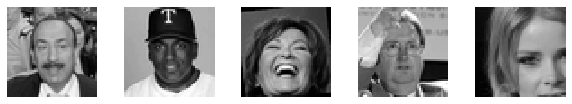

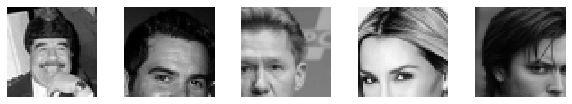

In [91]:
test_Pmtcnn(0.6)
test_mtcnn(0.6)


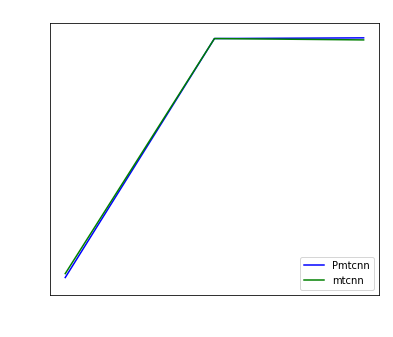

In [96]:
res= pd.read_csv(Results_File_Path)
res=res.tail(n=2)
res_Pmtcnn= res.loc[res.index[-2],['time_ms','recall','precision']]
res_mtcnn= res.loc[res.index[-1],['time_ms','recall','precision']]

categories=['time_ms','recall','precision']
models=['Pmtcnn', 'mtcnn']

results= [res_Pmtcnn, res_mtcnn]

colors= ['b', 'g']

plt.figure(figsize=(20,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([10, 105])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    
    plt.plot(categories, results[i], color=colors[i], label=models[i])

ax_2.set_title('Pmtcnn VS mtcnn',c='w')
ax_2.set_ylabel('Categories', fontsize=12,c='w')
ax_2.set_xlabel('Value', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

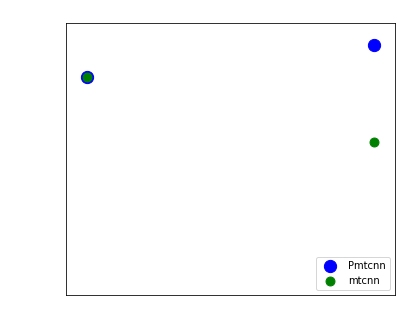

In [143]:
##cool and easy but doesnt look good with black background.
# res.plot(x="model_comment", y=['time_ms'], kind="bar",grid=True,ylim=(15,20))
# res.plot(x="model_comment", y=['recall'], kind="bar", grid=True,ylim=(99,100))
# res.plot(x="model_comment", y=['precision'], kind="bar",grid=True,ylim=(99,100))


res= pd.read_csv(Results_File_Path)
res=res.tail(n=2)
res_Pmtcnn= res.loc[res.index[-2],['recall','precision']] # ,
res_mtcnn= res.loc[res.index[-1],['recall','precision']] #,'recall','precision'

categories=['recall','precision']  # ,'recall','precision'
models=['Pmtcnn', 'mtcnn']

results= [res_Pmtcnn, res_mtcnn]

colors= ['b', 'g']

plt.figure(figsize=(20,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([98, 100])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    size= 150-(i * 70 )
    plt.scatter(categories, results[i], color=colors[i], label=models[i],s=size)


ax_2.set_title('Pmtcnn VS mtcnn',c='w')
ax_2.set_ylabel('Categories', fontsize=12,c='w')
ax_2.set_xlabel('Value', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

key left_eye  value (33, 27) key right_eye  value (50, 26) key nose  value (47, 39) key mouth_left  value (35, 49) key mouth_right  value (48, 48) 

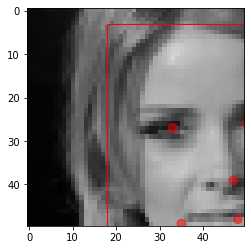

key left_eye  value (30, 29) key right_eye  value (47, 26) key nose  value (44, 40) key mouth_left  value (33, 49) key mouth_right  value (48, 46) 

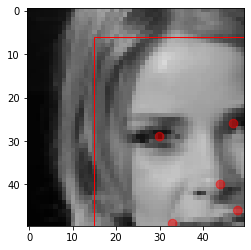

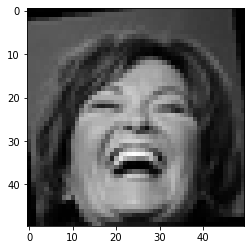

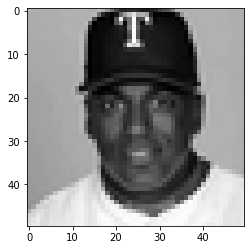

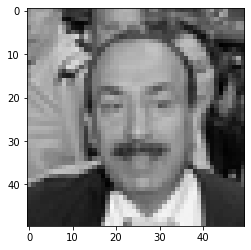

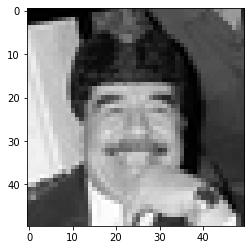

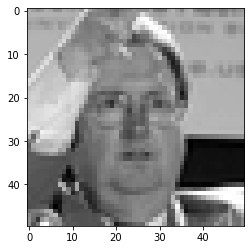

In [167]:
# draw wrond predictions with landmarks
with open(Wrong_Dir+'//'+'Pmtcnn_scale_0.6','rb') as handle:
    wrond_prediction_paths= pkl.load(handle)
model= mtcnn.MTCNN(scale_factor=0.6)
for p in wrond_prediction_paths:
    image = PIL.Image.open(p)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detections = model.detect_faces(pixels)
    draw_image_with_boxes(p, detections)

try transfer learning on Pnet

In [184]:
import pkg_resources
from mtcnn.network.factory import NetworkFactory

from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Activation,Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [240]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
weights_file = pkg_resources.resource_stream('mtcnn', 'data/mtcnn_weights.npy')
p_net, r_net, o_net = NetworkFactory().build_P_R_O_nets_from_file(weights_file)


In [14]:
p_net.summary()  

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, None, 1 280         input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_13 (PReLU)              (None, None, None, 1 10          conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, None, None, 1 0           p_re_lu_13[0][0]                 
____________________________________________________________________________________________

In [176]:
len(p_net.layers)-2


9

In [289]:
# layers_deleting= 2
# for i in range(len(p_net.layers)-layers_deleting):
#     p_net.layers[i].trainable = False
    
# my_layers = p_net.layers[len(p_net.layers)-layers_deleting].output
# my_layers = Dense(32,activation='relu')(my_layers)
# my_layers = Dense(1,activation="sigmoid")(my_layers)

# new_model = Model(inputs=p_net.input,outputs=my_layers)
# new_model.summary()

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

In [ ]:
# x=p_net.output
# x=GlobalAveragePooling2D()(x[0])
# #x=Flatten()(x[0])  #why isn't working?
# x=Dense(64,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(32,activation='relu')(x) #dense layer 2
# x=Dense(16,activation='relu')(x) #dense layer 3
# preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
# new_model= Model(inputs=p_net.input,outputs=preds)


In [38]:
# x=p_net.output
# x=GlobalAveragePooling2D()(x[0])
# #x=Flatten()(x[0])  #why isn't working?
# x=Dense(1024,activation='relu')(x) 
# x=Dense(512,activation='relu')(x)
# x=Dense(256,activation='relu')(x)
# preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
# new_model= Model(inputs=p_net.input,outputs=preds)


In [67]:
x=p_net.output
x=GlobalAveragePooling2D()(x[1])  # is there a better approach? here I took the face/no face output
#x=Flatten()(x[0])  #why isn't working?
x=Dense(256,activation='relu')(x)
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
new_model= Model(inputs=p_net.input,outputs=preds)


In [61]:
# x=p_net.output
# x=GlobalAveragePooling2D()(x[1])
# x=Dense(256,activation='relu')(x)
# preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
# new_model= Model(inputs=p_net.input,outputs=preds)


In [70]:
new_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 10)    280       
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, None, None, 10)    10        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, None, None, 10)    0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 16)    1456      
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, None, None, 16)    16        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 32)    464

In [69]:
for layer in new_model.layers[:10]:
    layer.trainable=False
for layer in new_model.layers[10:]:
    layer.trainable=True
    
for layer in new_model.layers:
    print(layer, layer.trainable, end= ' ')
    print("")

<keras.engine.input_layer.InputLayer object at 0x0000016336DDF248> False 
<keras.layers.convolutional.Conv2D object at 0x0000016336DDF488> False 
<keras.layers.advanced_activations.PReLU object at 0x0000016334ABB748> False 
<keras.layers.pooling.MaxPooling2D object at 0x0000016334ABBD08> False 
<keras.layers.convolutional.Conv2D object at 0x0000016336DEDE88> False 
<keras.layers.advanced_activations.PReLU object at 0x0000016336E05108> False 
<keras.layers.convolutional.Conv2D object at 0x0000016336E10408> False 
<keras.layers.advanced_activations.PReLU object at 0x0000016336E12988> False 
<keras.layers.convolutional.Conv2D object at 0x0000016336E16148> False 
<keras.layers.advanced_activations.Softmax object at 0x0000016336E0CB88> False 
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000016317B1B408> True 
<keras.layers.core.Dense object at 0x0000016317B1B708> True 
<keras.layers.core.Dense object at 0x00000163179C4FC8> True 


In [64]:
from tensorflow import keras
#from tensorflow.keras import layers

my_optimizer = keras.optimizers.Adam(lr=0.001)

In [65]:

new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(1024,activation='relu')(x) #dense layer 2
# x=Dense(512,activation='relu')(x) #dense layer 3
# preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

In [243]:
# compile the model



In [204]:
copy_to_data_generator_structure()

In [30]:
IMG_DIM = (50, 50)

train_files = glob.glob('data/train/aligned/*',recursive=True)
train_files.extend(glob.glob('data/train/negative/*',recursive=True))
print(len(train_files))
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)


validation_files = glob.glob('data/validation/aligned/*',recursive=True)
validation_files.extend(glob.glob('data/validation/negative/*',recursive=True))
print(len(validation_files))
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

1996
500
Train dataset shape: (1996, 50, 50, 3) 	Validation dataset shape: (500, 50, 50, 3)


In [31]:
train_labels = np.array(
    [1] * (train_imgs.shape[0] // 2) + [0] * (train_imgs.shape[0] // 2))

validation_labels = np.array(
    [1] * (validation_imgs.shape[0] // 2) + [0] * (validation_imgs.shape[0] // 2))

print(train_labels[997:999])
print(validation_labels[249:251])
# printing to verify correctness of vector

[1 0]
[1 0]


In [32]:
train_labels.shape

(1996,)

In [60]:
BatchSize= 2 #start with low number
Train_samples= train_imgs.shape[0]
Epochs= 50

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,  
                                   horizontal_flip=True,
                                   zca_whitening=True,
                                   brightness_range=[0.9,1.1],
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels, batch_size=BatchSize)
val_generator = val_datagen.flow(validation_imgs, validation_labels, batch_size=BatchSize)

history = new_model.fit_generator(train_generator, steps_per_epoch= Train_samples//BatchSize,
                              epochs=Epochs,     
                              validation_data=val_generator, 
                              validation_steps=Train_samples//BatchSize , 
                              verbose=1) 


epoch 10 batch 10  #m: 0.6618 - val_loss: 1.9391 - val_acc: 0.8287 - val_f1_m: 0.5745 - 
#val_precision_m: 0.6022 - val_recall_m: 0.5716

Epoch 100/100
 10s 10ms/step - loss: 0.3443 - acc: 0.8507 - f1_m: 0.6513 - precision_m: 0.6548 - recall_m: 0.6708 -
val_loss: 0.0356 - val_acc: 0.8662 - val_f1_m: 0.6540 - val_precision_m: 0.6588 - val_recall_m: 0.6678
                    
                    Epoch 100/100
998/998- 11s 11ms/step - 
loss: 0.3435 - acc: 0.8512 - f1_m: 0.6580 - precision_m: 0.6593 - recall_m: 0.6814
val_loss: 0.0227 - val_acc: 0.8642 - val_f1_m: 0.6420 - val_precision_m: 0.6428 - val_recall_m: 0.6608
                    
                    

fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)





verifying results one last time for previous models

In [ ]:
# uncomment "show random"
print("test_haarCascade")
test_haarCascade()
print("test_cvlib")
test_cvlib()
# print("test_YOLOv3")  #stopped-took too much time.
# test_YOLOv3()
print("test_mtcnn")
test_mtcnn(0.6)
print("test_Bmtcnn")
test_Bmtcnn(0.6)
print("test_Pmtcnn")
test_Pmtcnn(0.6)



,model_comment,time_ms,accuracy,recall,precision
66,Pretrained\n cv2_haarCascade_scale_1.02_minNei...,3.42,98.56,97.52,99.59
67,Pretrained\n cvlib_threshold_0.5,51.93,82.89,100.00,74.51
68,Pretrained\n mtcnn_scale_0.6,18.27,98.80,98.48,99.11
69,Pretrained\n Bmtcnn_scale_0.6,34.60,49.68,98.48,49.84
70,Pretrained\n Pmtcnn_scale_0.6,19.78,99.16,98.48,99.84


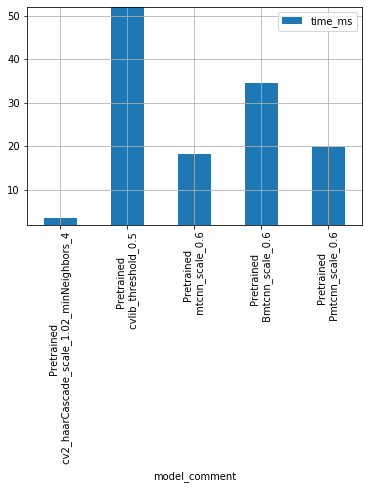

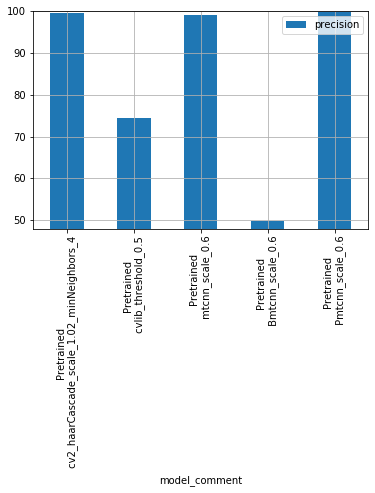

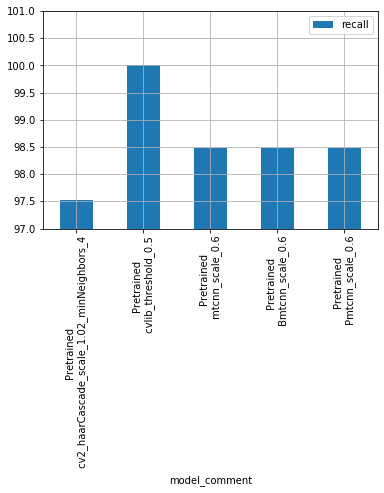

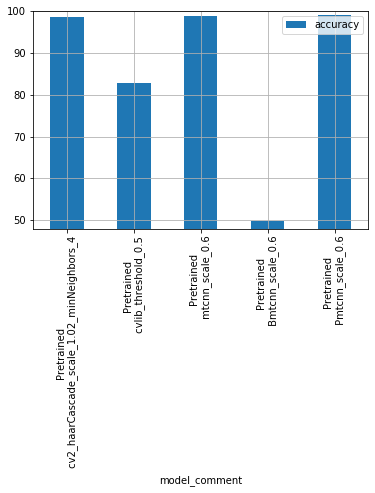

In [20]:
res= pd.read_csv(Results_File_Path)
res= res.tail(n=5)

res.plot(x="model_comment", y=['time_ms'], kind="bar",grid=True,ylim=(2,52))
res.plot(x="model_comment", y=['precision'], kind="bar",grid=True,ylim=(48,100))
res.plot(x="model_comment", y=['recall'], kind="bar",grid=True,ylim=(97,101))
res.plot(x="model_comment", y=['accuracy'], kind="bar",grid=True,ylim=(48,100))
#res.round(["time_ms","accuracy","recall","precision"],2)

res=res.round({'time_ms': 2, 'accuracy': 2, 'recall': 2, 'precision': 2 })
res= res.loc[:,["model_comment","time_ms","accuracy","recall","precision"]]
res.head()

verify people can use my model

In [22]:
model=Pmtcnn()
with open('bestModel.pkl','wb')as handle:
    pkl.dump(model, handle)  

In [24]:
with open('bestModel.pkl','rb')as handle:
    best= pkl.load(handle)  


C:\Users\tunik\Miniconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [1]:
import Pmtcnn
import PIL

Using TensorFlow backend.


In [2]:
lev_mtcnn=Pmtcnn.Pmtcnn()

In [4]:
image = PIL.Image.open('test.png')
res_pmtcnn= lev_mtcnn.transform_detect_aligned(image)
res_pmtcnn

False